# Projet Fil Rouge :  Détection d'activité humaine - Machine Learning

**Nom du Groupe :**

**Noms : Camara, Drai**

**Prénoms : Ababacar, Benjamin**



Dans ce projet, nous essaierons de prédire l'activité humaine (1-Descendre, 2-Courir, 3-Assis, 4-Debout, 5-Monter ou 6-Marcher) en utilisant les capteurs du smartphone. C'est-à-dire qu'en utilisant les méthodes suivantes, le smartphone peut détecter ce que nous faisons en ce moment.


En utilisant l'accéléromètre  intégré dans le smartphone,  l'accélération linéaire 3-axes à un taux constant de 50Hz ont été relevées. Les expériences ont été enregistrées sur vidéo pour étiqueter les données manuellement. 

<img src="files/HARDataset.JPG" width="800" height="600"  >

Il est fourni pour chaque enregistrement de l'ensemble de données : 
- L'accélération triaxiale de l'accéléromètre (accélération totale)
- Son étiquette d'activité. 
- Un identifiant du sujet qui a réalisé l'expérience.


Ces 6 séances se décomposent en 6 parties : 
- Partie 0 : Familiarisation avec les données 
- Partie I : Sélection de variables et pénalisation
- Partie II : Classification par méthodes à noyau 
- Partie III : Apprentissage par ensemble : Adaboost, gradient boosting
- Partie IV : Classification par réseaux de neurones
- Partie V : Votre étude


**Travail à rendre**

Pour cela, vous devez :
1. Réaliser une étude sur le signal de l'accéléromètre et une avec leur représentation fréquentielle; 
2. Evaluer les résultats en utilisant la matrice de confusion et le pourcentage de bonne classification;
4. Classification par méthodes à noyau, réseaux de neurones, 
5. Rédiger un rapport en pdf présentant votre étude : les résultats par  méthode et vos commentaires, comparaisons et conclusions sur une étude plus générale en modifiant les tailles des ensembles de test et d'apprentissage, en changeant le nombre de classes  (Longeur max. : 10 pages).


**Dataset et description :**
https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+





In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import math
import scipy as sc
import seaborn as sns

In [2]:
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]

DATA_PATH = './WISDM_ar_v1.1_raw.txt'


# Data preprocessing
TIME_STEP = 60

# Model
N_CLASSES = 3
N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration
SEGMENT_TIME_SIZE = 30
TAILLE_TEST=40
TAILLE_APP=20

##  Création des données d'apprentissage et de test

In [3]:
np.random.seed(47)

Classe N° 0
Classe N° 1
Classe N° 2
(60, 90)
(120, 90)


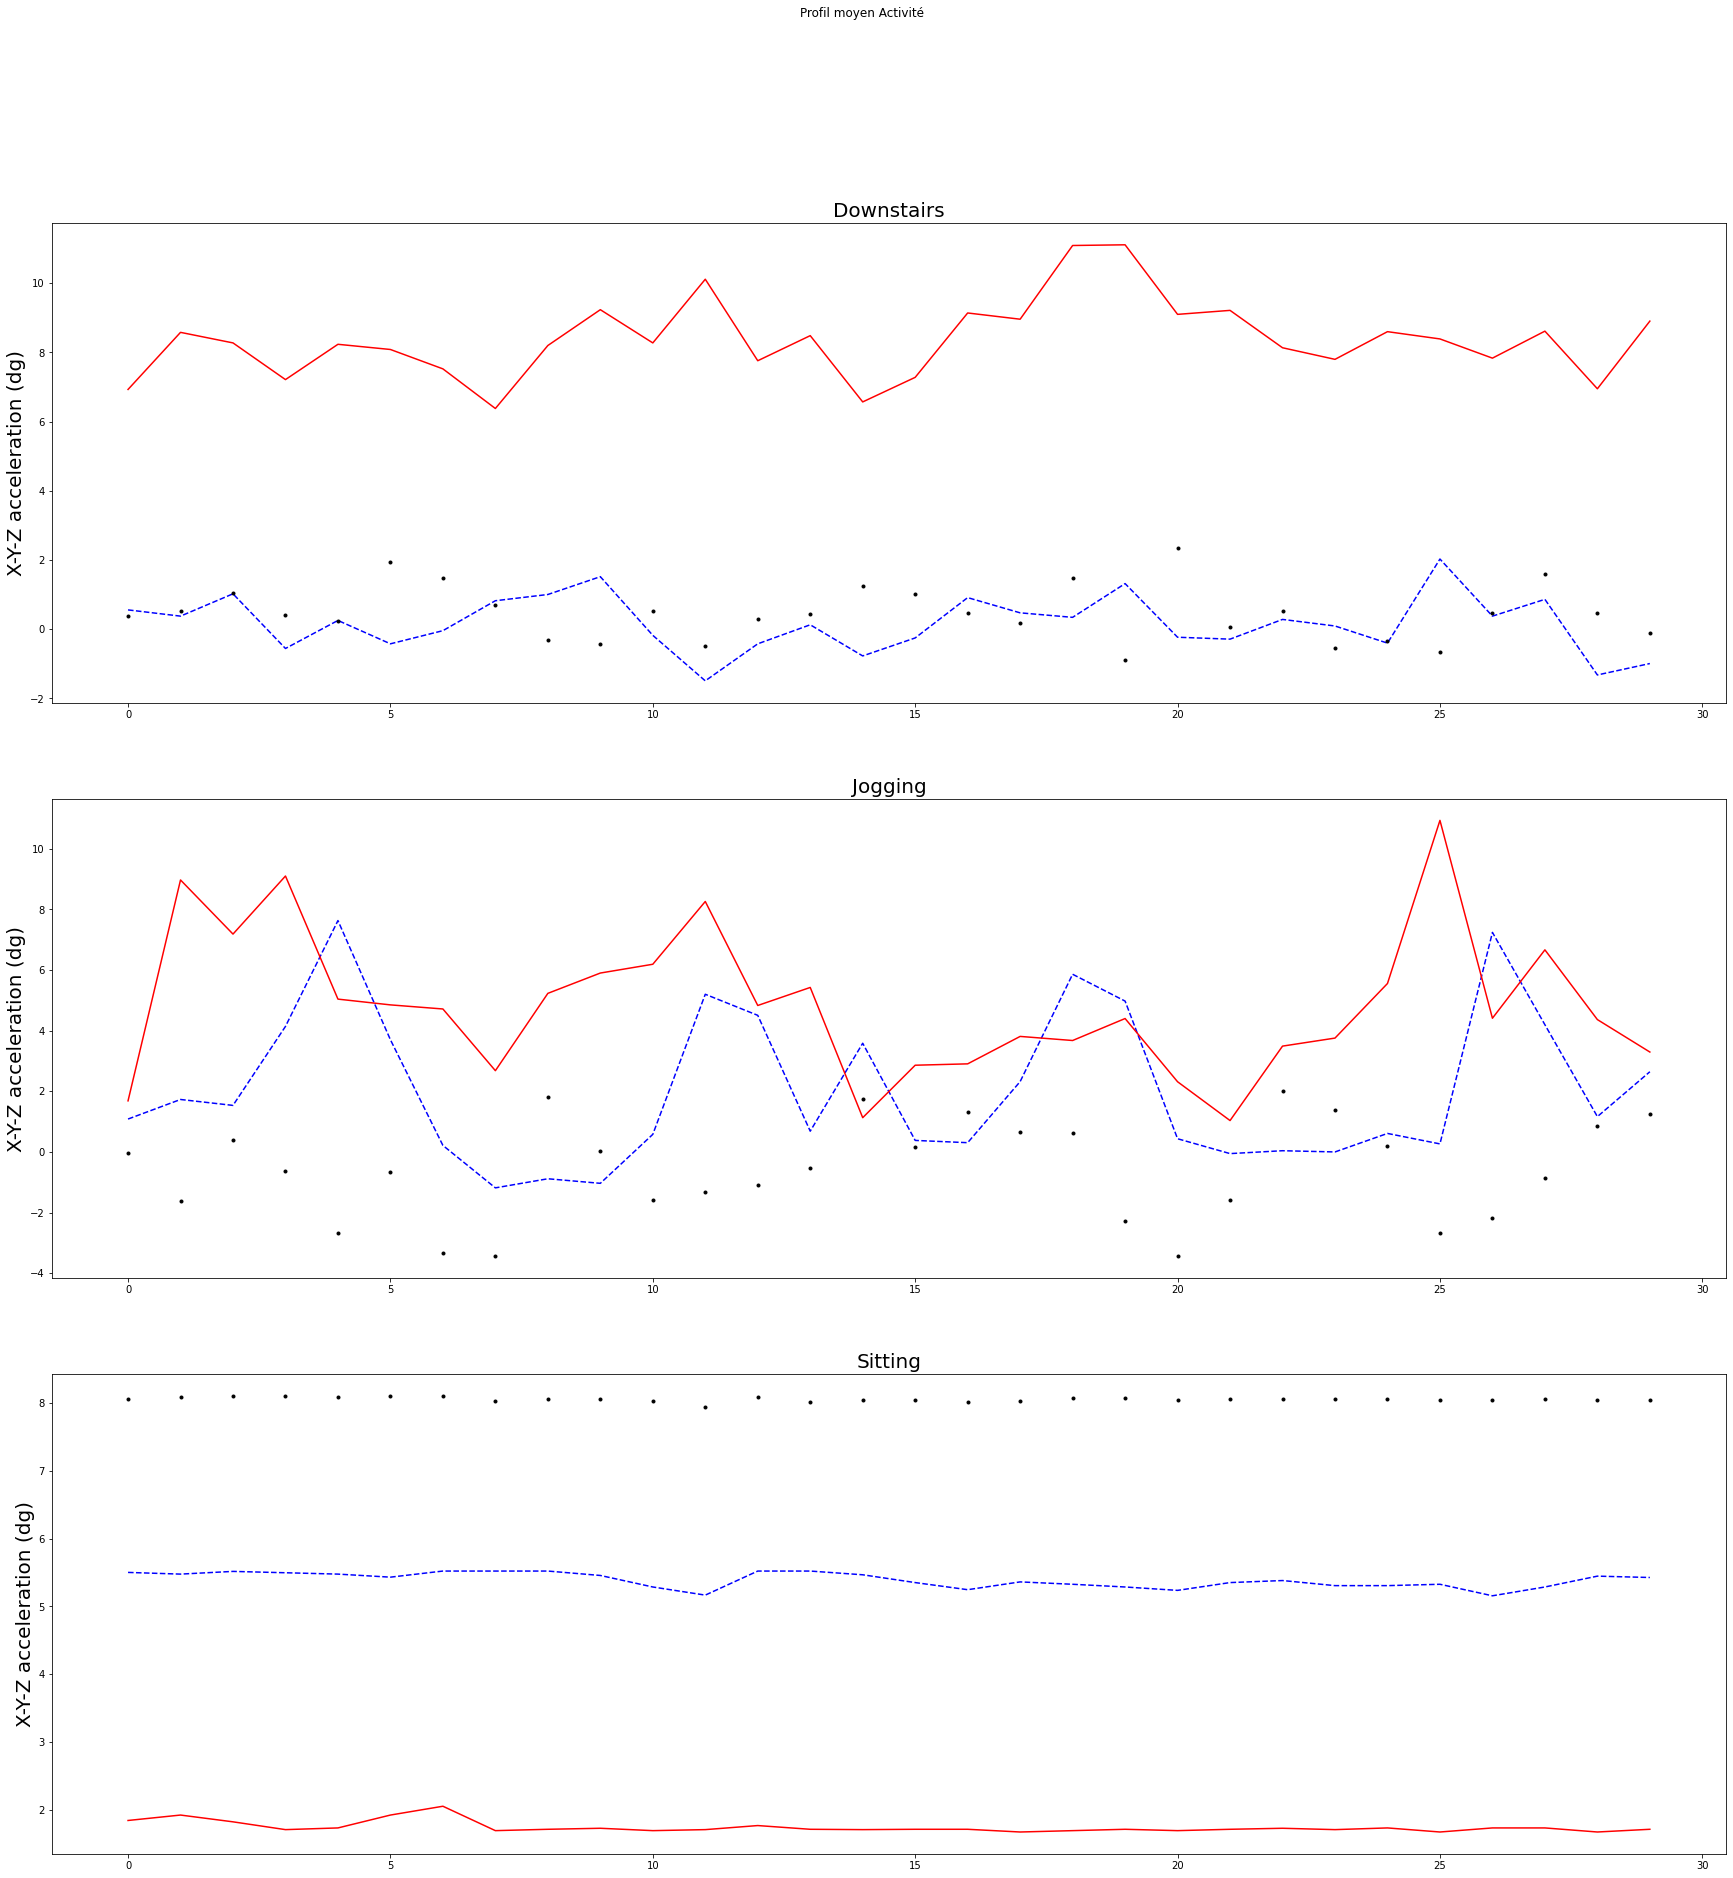

In [4]:

# Chargement des données 
data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
data['z-axis'].replace({';': ''}, regex=True, inplace=True)
data = data.dropna()


data_convoluted = []
labels = []



# Prendre des segments temporels de taille SEGMENT_TIME_SIZE 
# tous les TIME_STEP pour une même activité
for j in range(0,N_CLASSES):
    DataBest=data[data['activity'] == LABELS[j]]
    for i in range(0, len(DataBest) - SEGMENT_TIME_SIZE, TIME_STEP):
        x = DataBest['x-axis'].values[i: i + SEGMENT_TIME_SIZE]
        y = DataBest['y-axis'].values[i: i + SEGMENT_TIME_SIZE]
        z = DataBest['z-axis'].values[i: i + SEGMENT_TIME_SIZE]
        data_convoluted.append([x, y, z])
    # Label de l'activité associée à chaque segment
        label = j
        labels.append(label)


# Conversion numpy
data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)

labels = np.asarray(labels, dtype=np.int)
#print("Convoluted data shape: ", data_convoluted.shape)
#print("Labels shape:", labels.shape)


fig, axs = plt.subplots(N_CLASSES,figsize=(30,30))
fig.suptitle('Profil moyen Activité')

profil_median=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
List_Data_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
Label_Test=np.zeros((N_CLASSES*TAILLE_TEST,1))
Label_App=np.zeros((N_CLASSES*TAILLE_APP,1))

for i in range(N_CLASSES):
    # Selection des données correspondant à la classe i
    print('Classe N°',i)
    res=np.where(labels==i)
    res=np.array(res)
    res=np.ravel(res)
    taille=res.shape[0]
    
    # Création de la base d'Apprentissage
    tirage=np.random.randint(0,taille,TAILLE_TEST+TAILLE_APP)
    tir_dataApp=data_convoluted[res[tirage[0:TAILLE_APP]],:,:]
    Data_App[i*TAILLE_APP:(i+1)*TAILLE_APP,:]=np.reshape(tir_dataApp,(TAILLE_APP,SEGMENT_TIME_SIZE*N_FEATURES))
    Label_App[i*TAILLE_APP:(i+1)*TAILLE_APP]=i
    
    
    # Création de la base de Test
    List_Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=res[tirage[TAILLE_APP:]]
    Label_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=i
    tir_dataTest=data_convoluted[res[tirage[TAILLE_APP:]],:,:]
    Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST,:]=np.reshape(tir_dataTest,(TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))

    # Affichage du profil temporel moyen de la classe
    class1=np.median(tir_dataApp,axis=0)
    profil_median[i,:,:]=class1
    
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,0],'b--')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,1],'r-')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,2],'k.')
    axs[i].set_ylabel('X-Y-Z acceleration (dg)',fontsize=20)
    axs[i].set_title(LABELS[i], fontsize=20)

print(Data_App.shape)

print(Data_Test.shape)

# Partie 0 : Familiarisation avec les données 

Il s'agit dans cette partie de ce familiariser avec les données en tracant différentes données caractéristiques comme la moyenne, la variance et la médiane. On peut même visualiser les données par une Analyse en composante principale.
Vous pouvez aussi considérer une représentation spectrale des données par une transformation de Fourier . 

In [5]:
from sklearn.decomposition import PCA
from scipy.fft import fft, ifft

In [6]:
Data_Tot = np.vstack((Data_App, Data_Test))
print(Data_Tot.shape)

(180, 90)


In [7]:
pca = PCA()
Data_PCA = pca.fit_transform(Data_App)
print(Data_PCA.shape)

(60, 60)


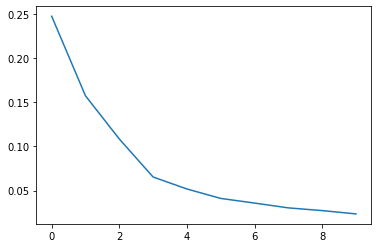

In [8]:
plt.plot(pca.explained_variance_ratio_[0:10])
plt.show()

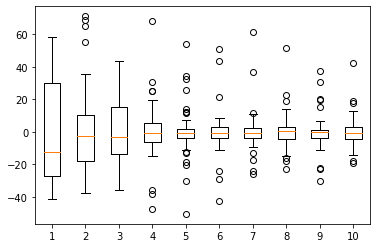

In [9]:
plt.boxplot(Data_PCA[:,0:10])
plt.show()

In [10]:
Data_App_Reduce = Data_PCA[:, 0:5]
print(Data_App_Reduce.shape)

(60, 5)


Représentation spectrale des données avec la transformation de Fourier

In [11]:
Data_Fourier = fft(Data_App)

# Partie I : Sélection de modèles et pénalisation

### 1. Régression Multiclasse

Appliquer un modèle de **régression multiclasses**.

On modélise les probabilités par la forme suivante :

$$
\mathbb{P}(Y_i = j) = \frac { \exp{-\beta_j^{T} X_i } } { 1 + \sum_{\ell = 1}^{K-1} \exp{-\beta_\ell^{T} X_i }}, 
$$
Pour tout $j$ dans $\{ 1,2, \dots , K-1 \}$.

On peut aussi considérer un modèle binomiale par classe pour l'analyse. i.e (Considérer les labels dans la classe $k$ comme étant 1 et les autres labels 0)

Pour votre étude, On vous proposera les comparaisons suivantes (liste exhaustive) : 

1. Essayer différents type d'optimiseurs disponibles dans la librairie Sklearn (lbfgs, saga, sag, newton-cg) et comparer la vitesse de convergence.

2. Faire varier le coefficient de régularisation $C$ (<span style="color:red"> **Il y a toujours une régularisation par défaut dans sklearn** </span>) et comparer son effet sur la performance.

3. Modèle binomiale versus Régression multinomiale. 

4. Le rescaling des donnés améliore t-il la performance ? 


### 2. Modèle de régression multiclasse

In [12]:
# Modèle de régression 
from sklearn.linear_model import LogisticRegression

solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
list_reg = []
list_pred = []
for method in solver :
    reg = LogisticRegression(random_state=47,solver = method,max_iter = 10000).fit(Data_App, np.ravel(Label_App))
    list_reg.append(reg)
    pred = reg.predict(Data_Test)
    list_pred.append(pred)

### 3. Evaluation des résultats 

Evaluer le résultat par matrice de confusion et pourcentage de bonne classification.

*Conseil :* Pensez à mettre une fonction pour afficher la matrice de confusion

In [14]:
# Evaluation des résultats par matrices de confusion 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(real_value, predictions, solver):
    cm =confusion_matrix(real_value, predictions)
    acc_score = accuracy_score(real_value, predictions)
    index = ['Downstairs','Jogging','Sitting']  
    columns = ['Downstairs','Jogging','Sitting']
    
    cm_df = pd.DataFrame(cm,columns,index)                      
    plt.figure(figsize=(10,6))
    plt.title("Confusion Matrix with {}".format(solver))
    sns.heatmap(cm_df, annot=True)
    print("Accuracy Score with {} : {}%".format(solver, round(acc_score*100, 2)))


Accuracy Score with newton-cg : 60.83%
Accuracy Score with lbfgs : 60.83%
Accuracy Score with liblinear : 67.5%
Accuracy Score with sag : 68.33%
Accuracy Score with saga : 70.0%


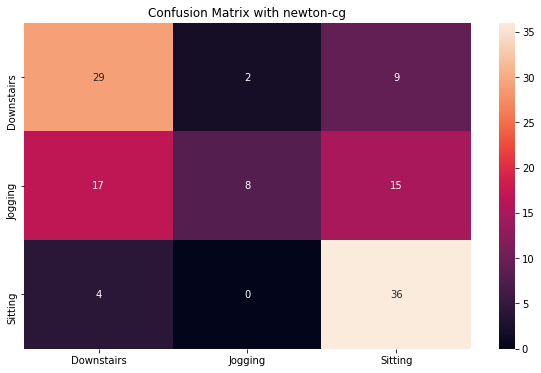

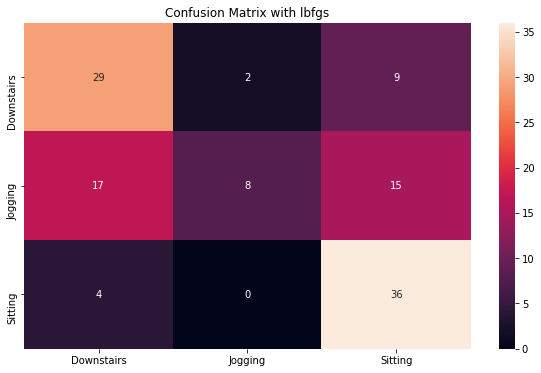

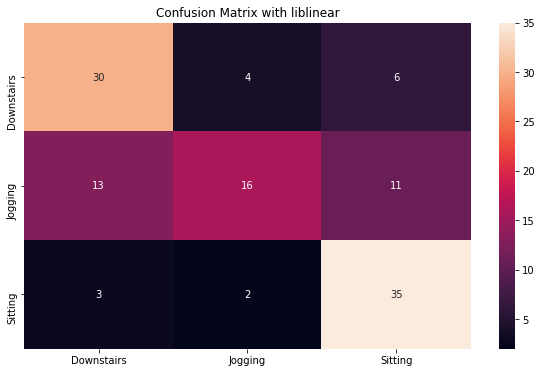

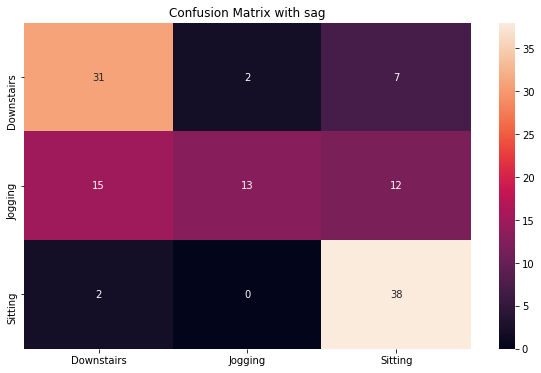

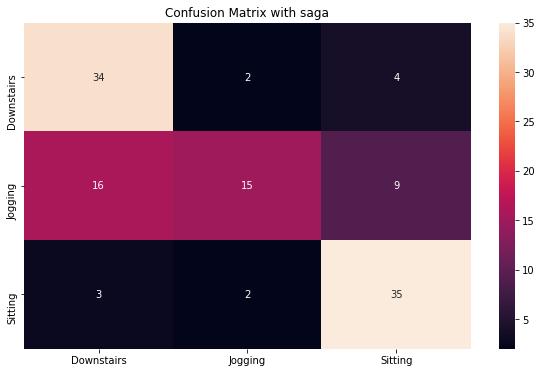

In [15]:
for k in range(len(list_pred)) :
    print_confusion_matrix(Label_Test, list_pred[k], solver[k])

### 4. Variations du paramètres de Pénalisation 

In [16]:
from sklearn.model_selection import GridSearchCV

params = {"C":[k*0.01 for k in range(1, 100)]}
estimateur = LogisticRegression(random_state=47,solver = "lbfgs",multi_class = "multinomial",max_iter = 2000)
reg = GridSearchCV(estimator = estimateur,param_grid =params,cv = 10,n_jobs=-1)
reg = reg.fit(Data_App,np.ravel(Label_App))

Affichage des résultats

In [17]:
print(reg.best_params_)

{'C': 0.01}


Accuracy Score with lbfgs : 70.0%


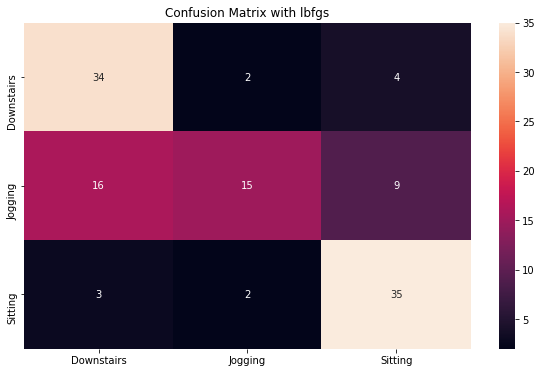

In [18]:
print_confusion_matrix(Label_Test, pred,"lbfgs")

### 5. Rescaling des données

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Data_App_Standard = scaler.fit_transform(Data_App)
reg= LogisticRegression(random_state=47,solver="saga",C=0.1,max_iter = 10000).fit(Data_App_Standard,np.ravel(Label_App))
pred = reg.predict(Data_Test)

### Variations des optimiseurs utilisés

In [20]:
scaler = StandardScaler()
Data_App_Standard = scaler.fit_transform(Data_App)
params = {"C":[0.1,0.3,0.8,1,5,10,20],"solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
estimateur = LogisticRegression(random_state=47,max_iter = 10000)
reg = GridSearchCV(estimator = estimateur,param_grid =params,cv = 10,n_jobs=-1)
reg = reg.fit(Data_App,np.ravel(Label_App))
pred = reg.predict(Data_Test)

Affichage des résultats

Accuracy Score with saga : 70.0%


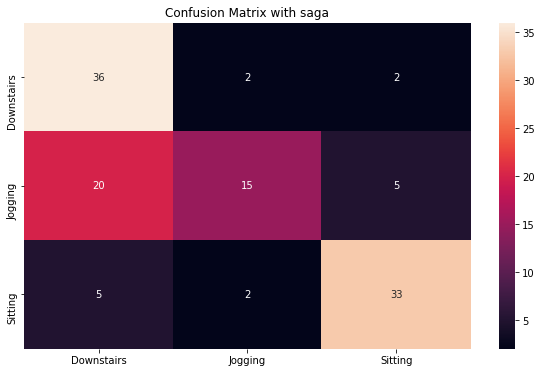

In [21]:
print_confusion_matrix(Label_Test, pred,"saga")

### Ajout d'un terme de pénalisation Lasso

Dans un cadre générique, la pénalisation Lasso revient à régulariser une fonction perte par une norme $\ell_1$. 

Cette régularisation a tendance à offrir une solution parcimonieuse en éliminant un certain nombre de variables. 
Plusieurs applications sont disponibles: Réduction de dimension, Interprétabilité des modèles.



**Inconvénient:** plus difficile à optimiser (car non lisse). LBFGS et newton-CG ne sont pas disponibles. Sklearn propose SAGA et liblinear.

On vous propose les méthodes suivantes à essayer : 
 

1. Variation du paramètre de Régularisation 

2. Mélange entre Lasso et pénalité $\ell_2$

**l_1 ratio** : réel compris entre 0 et 1.  Le mélange entre la pénalité $\ell_1$ et la pénalité $\ell_2$. 

Si 1, alors c'est du Lasso Complet et si 0, il s'agit de la pénalisation $\ell_2$. 





In [22]:
from sklearn.model_selection import GridSearchCV
params = {"C":[0.1,0.3,0.8,1,5,10,20],"l1_ratio":[0,0.1,0.2,0.5,0.6,0.9,1]}
estimateur = LogisticRegression(penalty="elasticnet",random_state=47,max_iter = 10000, solver="saga")
reg = GridSearchCV(estimator = estimateur,param_grid =params,cv = 10,n_jobs=-1)
reg = reg.fit(Data_App,np.ravel(Label_App))
pred = reg.predict(Data_Test)

Affichage des résultats

In [23]:
print(reg.best_params_)

{'C': 0.1, 'l1_ratio': 1}


Accuracy Score with saga : 65.83%


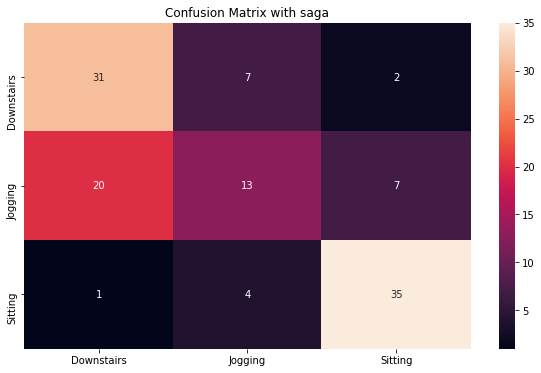

In [24]:
print_confusion_matrix(Label_Test, pred,"saga")




# Partie II : Classification par méthodes à noyau

**Rappel** Les méthodes à noyau consistent à plonger les données dans un espace de dimension de Hilbert $\mathcal{H}$ ou on espère que les donnés pourront être séparées linéairement. 

**Theorème de Représentation :** La solution du problème de séparation en dimension infinie est contenue dans un sous espace vectoriel de dimension finie de $\mathcal{H}$ 

### 1. Réaliser une classification par SVM à noyau

    1) Varier le noyau
    2) Varier le paramètre de régularisation.






In [25]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

params = {"kernel": ("linear", "poly", "rbf", "sigmoid"), 'C':list(np.linspace(0.1, 10, 200)) }
svc = SVC()
clf = GridSearchCV(estimator=svc, param_grid=params, cv = 10,n_jobs=-1)
# clf = make_pipeline(StandardScaler(), SVC(params))
# clf = GridSearchCV(estimator = SVC(gamma='auto') ,param_grid =params,cv = 10,n_jobs=-1)

clf.fit(Data_App, np.ravel(Label_App))
pred = clf.predict(Data_Test)

### Evaluer les résultats par matrice de confusion 

In [26]:
print(clf.best_params_)

{'C': 0.1, 'kernel': 'rbf'}


Accuracy Score with SVM : 86.67%


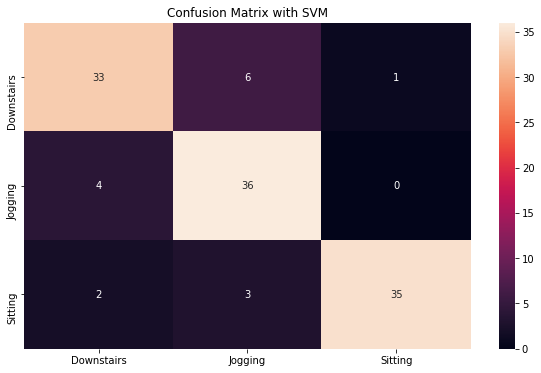

In [27]:
print_confusion_matrix(Label_Test, pred,"SVM")

### 2.  Classification spectrale 

 On peut aussi transposer à l'espace de Hilbert $\mathcal{H}$ des algos classiques de $\mathbb{R}^d$ comme la Classification spectrale.
 
 Réaliser une classification spectrale non supervisée sur les données. Interpréter les résultats 

Accuracy Score with Spectral Clustering : 53.89%


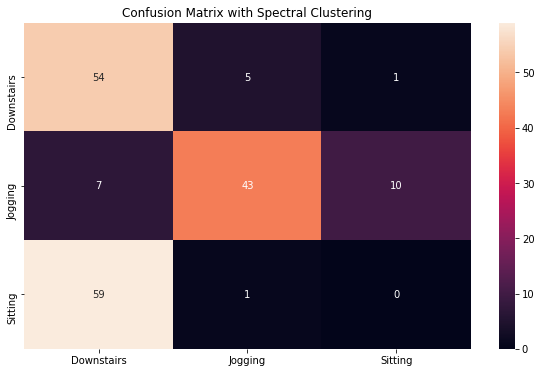

In [48]:
from sklearn.cluster import SpectralClustering

Label_Tot = np.vstack((Label_App, Label_Test))
clustering = SpectralClustering(n_clusters=3, assign_labels="discretize", random_state=47, affinity="rbf", kernel_params = {"gamma": [0.001, 1]})
Scaled_Data_Tot = StandardScaler().fit_transform(Data_Tot)
pred = clustering.fit_predict(Scaled_Data_Tot)
print_confusion_matrix(Label_Tot, pred,"Spectral Clustering")

# Partie III : Apprentissage par ensemble 

## 1. Adaptive Boosting : AdaBoost 

Adaboost repose sur la sélection itérative de classifieur faible en fonction d'une distribution des exemples d'apprentissage. Chaque exemple est pondéré en fonction de sa difficulté avec le classifieur courant. 

Réaliser une classification par adaboost et étudier 

Accuracy Score with AdaBoost : 57.5%


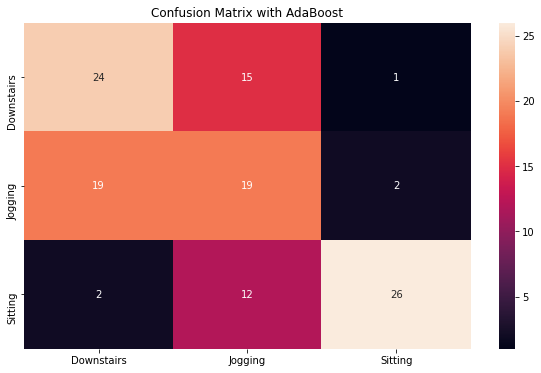

In [36]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=100, random_state=47).fit(Data_App, np.ravel(Label_App))
pred = clf.predict(Data_Test)
print_confusion_matrix(Label_Test, pred, "AdaBoost")

## 2. Gradient Boosting

Le Gradient Boosting permet l'optimisation de fonctions de perte différentiables arbitraires. Il permet d'optimiser la fonction de perte de l'apprenant précédent en ajoutant un nouveau modèle adaptatif qui combine des apprenants faibles.

Etudier sur la fonction de perte et le taux d'apprentissage.

Accuracy Score with Gradient Boosting : 69.17%


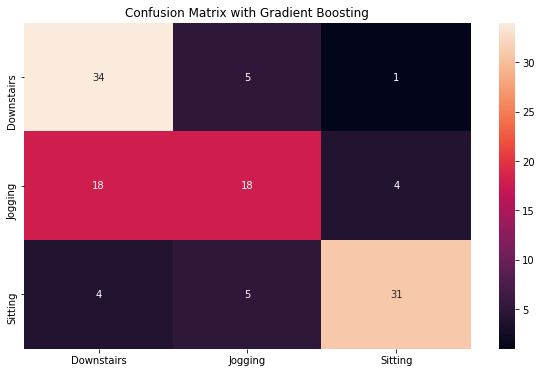

In [52]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=47).fit(Data_App, np.ravel(Label_App))
pred = clf.predict(Data_Test)
print_confusion_matrix(Label_Test, pred, "Gradient Boosting")

**Evaluation de la classification**

Utiliser la validation croisée pour évaluer les résultats 

In [53]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(clf, Data_Test, np.ravel(Label_Test), cv=3))

[0.75  0.675 0.85 ]


# Partie IV : Classification par réseaux de neurones

1. Réaliser une classification via les réseaux de neurones
2. Evaluer les résultats par matrice de confusion par exemple, fonction de perte...
3. Tester différentes architectures et différents solveurs

In [ ]:
from sklearn.neural_network import MLPClassifier

# Partie V : votre étude

Réalisez votre propre étude en :
- en augmentant les bases de test et/ou d'apprentissage et/ou la durée des segments 
- en proposant des variantes des méthodes proposées ou en utilisant d'autres
- en rajoutant davantage de classes (jusqu'à 3 supplémentaires : 4-Debout, 5-Monter ou 6-Marcher ) 
- en comparant analyses temporelle et fréquentielle
le tout en testant les différentes approches et en interprétant les résultats, à synthétiser sur un rapport. 


